# EDA for Merged Wildfire Detection Dataset

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

plt.style.use('seaborn-v0_8-dark')

np.random.seed(7)

In [2]:
BASE_DIR = "../"
DATA_DIR = os.path.join(BASE_DIR, "data")
MERGED_DATASET_NAME = "merged_wildfire_dataset"
MERGED_DATASET_DIR = os.path.join(DATA_DIR, MERGED_DATASET_NAME)

SPLITS = ["train", "valid", "test"]
ANNOTATION_FILENAME = "_annotations.coco.json"

In [3]:
def check_images_without_boxes(split_name: str):
    """
    Check the specified data split for images without any annotations.
    
    This function analyzes a COCO format annotation file to identify images that have no
    corresponding bounding box annotations. It prints the results of the analysis including
    any found images without annotations.

    Args:
        split_name (str): Name of the dataset split to check (e.g. "train", "valid", "test")

    Returns:
        None: This function prints its output directly and does not return any values
    """
    print(f"\n--- Checking split: {split_name} ---")
    
    split_dir = os.path.join(MERGED_DATASET_DIR, split_name)
    annotation_file_path = os.path.join(split_dir, ANNOTATION_FILENAME)

    if not os.path.exists(annotation_file_path):
        print(f"Annotation file not found: {annotation_file_path}")
        return

    try:
        with open(annotation_file_path, 'r') as f:
            coco_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error reading JSON file: {annotation_file_path}")
        return

    images_without_annotations = []
    
    image_id_to_annotations = defaultdict(list)
    for ann in coco_data.get('annotations', []):
        image_id_to_annotations[ann['image_id']].append(ann)

    if 'images' in coco_data:
        for image_info in coco_data['images']:
            img_id = image_info['id']
            img_filename = image_info['file_name']
            
            if not image_id_to_annotations[img_id]:
                images_without_annotations.append(img_filename)
    else:
        print(f"File {annotation_file_path} is missing 'images' key.")
        return

    if images_without_annotations:
        print(f"Found {len(images_without_annotations)} images without annotations:")
        for img_name in images_without_annotations:
            print(f"- {img_name}")
    else:
        print("All images have annotations.")

In [4]:
for split in SPLITS:
    images_to_delete = check_images_without_boxes(split)


--- Checking split: train ---
Found 45 images without annotations:
- CBERS_4A_WFI_20200805_214_140_L4_6827_4031_3_png_jpg.rf.8e3fef8d5d957db4c033329f8128ae80.jpg
- CBERS_4A_WFI_20200801_221_140_L4_6573_3286_5_png_jpg.rf.90305e54dc55732c581a4d03918ff0b7.jpg
- CBERS_4A_WFI_20200727_222_132_L4_2925_3901_9_png_jpg.rf.927366ce20f84e9f6b5b28d359e67ee5.jpg
- CBERS_4A_WFI_20200806_220_132_L4_2194_5946_6_png_jpg.rf.96d3e561ce9710c11476c62a356b3f59.jpg
- CBERS_4A_WFI_20200810_213_132_L4_2627_6590_6_png_jpg.rf.976dc03c3675ff6a69c817e24d0f4031.jpg
- CBERS_4A_WFI_20200810_213_132_L4_2661_6489_5_png_jpg.rf.980891cb77ed203355a679becc4b0415.jpg
- CBERS_4A_WFI_20200810_213_132_L4_2627_6590_6_png_jpg.rf.a6173edc101bbf176210b9717df49b40.jpg
- CBERS_4A_WFI_20200810_213_132_L4_2661_6489_5_png_jpg.rf.b140b03f4d04c5bd59d8f39ab35d9903.jpg
- CBERS_4A_WFI_20200726_216_140_L4_4943_4008_8_png_jpg.rf.39f2e2af81acf50001a80fb574664602.jpg
- CBERS_4A_WFI_20200721_217_132_L4_3011_3873_4_png_jpg.rf.3a869d24f0b52bc7a2d

In [5]:
def load_coco_annotations(ann_file_path: str):
    """
    Load COCO format annotation file from the given path.
    Args:
        ann_file_path (str): Path to the COCO annotation JSON file

    Returns:
        dict | None: Dictionary containing the COCO annotations data if file exists,
                    None if file not found
    """
    if not os.path.exists(ann_file_path):
        print(f"Annotation file not found: {ann_file_path}")
        return None
    with open(ann_file_path, 'r') as f:
        data = json.load(f)
    return data

## Dataset Overview

In [6]:
dataset_stats = {}
all_categories_map = {}

for split in SPLITS:
    split_path = os.path.join(MERGED_DATASET_DIR, split)
    ann_file = os.path.join(split_path, ANNOTATION_FILENAME)
    
    print(f"\n--- Processing Split: {split} ---")
    data = load_coco_annotations(ann_file)
    
    if data:
        num_images = len(data.get('images', []))
        num_annotations = len(data.get('annotations', []))
        
        current_categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
        for cat_id, cat_name in current_categories.items():
            if cat_id not in all_categories_map:
                all_categories_map[cat_id] = cat_name
            elif all_categories_map[cat_id] != cat_name:
                print(f"Warning: Category ID {cat_id} has conflicting names: '{all_categories_map[cat_id]}' and '{cat_name}'")
                
        category_counts = {name: 0 for name in current_categories.values()}
        for ann in data.get('annotations', []):
            cat_id = ann['category_id']
            if cat_id in current_categories:
                category_counts[current_categories[cat_id]] += 1
            else:
                print(f"Warning: Annotation with unknown category_id {cat_id} in {split} split.")
                
        dataset_stats[split] = {
            "num_images": num_images,
            "num_annotations": num_annotations,
            "category_counts": category_counts,
            "categories_present": current_categories
        }
        
        print(f"Number of images: {num_images}")
        print(f"Number of annotations: {num_annotations}")
        print(f"Category counts: {category_counts}")
    else:
        dataset_stats[split] = {"num_images": 0, "num_annotations": 0, "category_counts": {}, "categories_present": {}}
        print(f"No data loaded for {split} split.")

print(f"\n--- Overall Unique Categories Found: {all_categories_map} ---")


--- Processing Split: train ---
Number of images: 4665
Number of annotations: 29104
Category counts: {'Wildfire': 29104, 'No Wildfire': 0}

--- Processing Split: valid ---
Number of images: 1354
Number of annotations: 8448
Category counts: {'Wildfire': 8448, 'No Wildfire': 0}

--- Processing Split: test ---
Number of images: 744
Number of annotations: 4247
Category counts: {'Wildfire': 4247, 'No Wildfire': 0}

--- Overall Unique Categories Found: {1: 'Wildfire', 2: 'No Wildfire'} ---


## Category Distributions

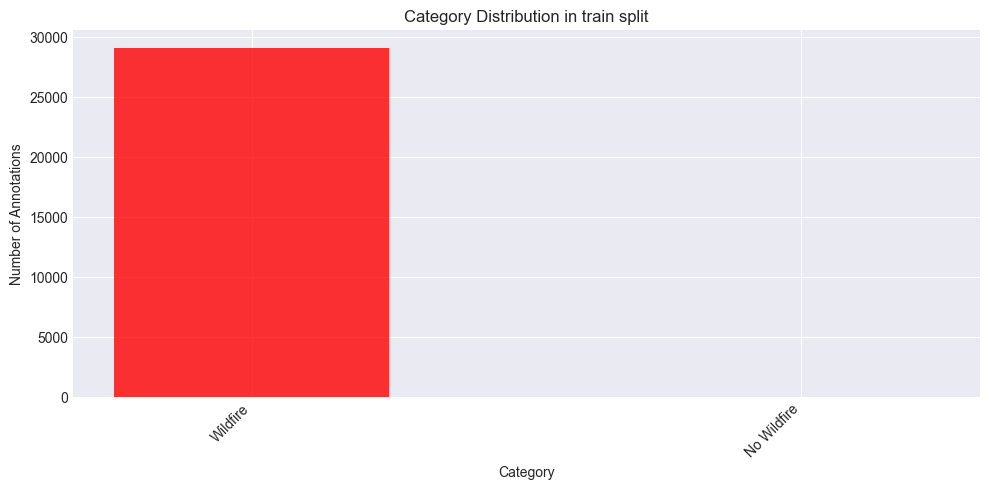

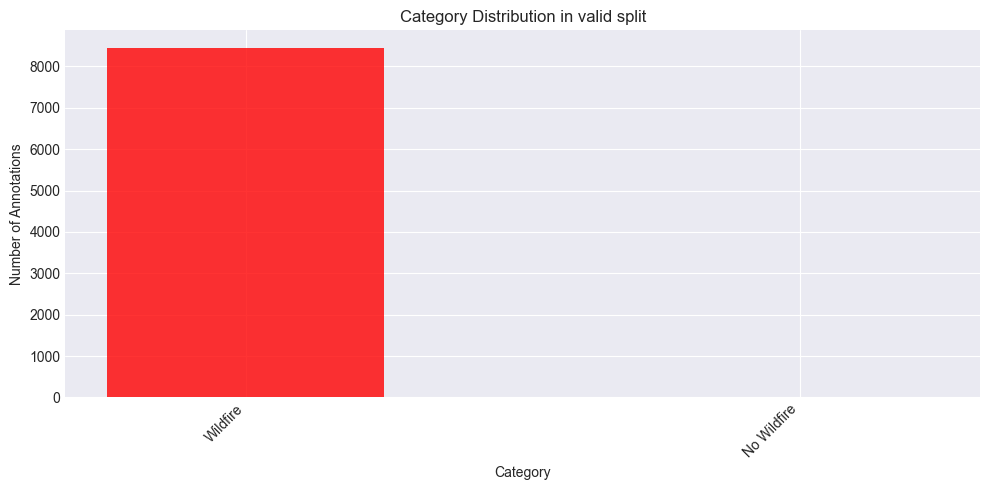

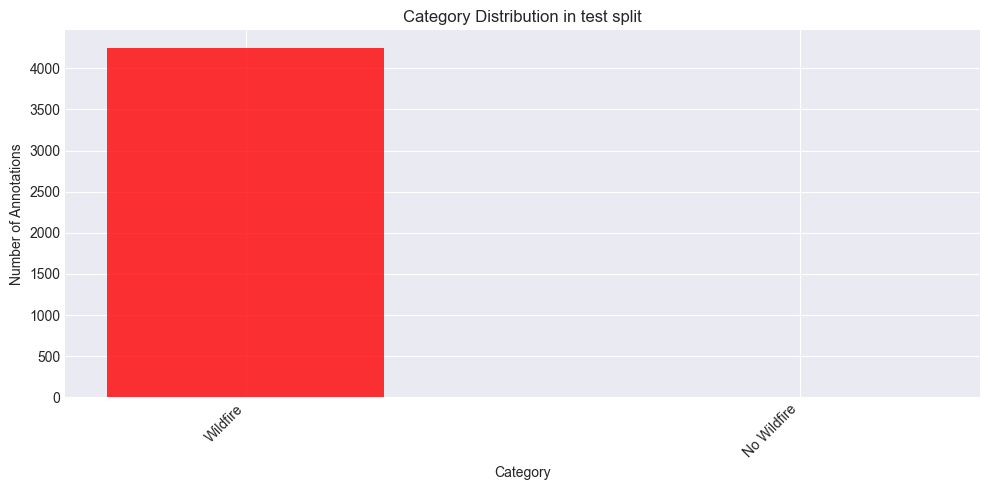

In [7]:
for split, stats in dataset_stats.items():
    if stats["num_annotations"] > 0:
        counts = stats["category_counts"]
        if counts:
            plt.figure(figsize=(10, max(5, len(counts) * 0.5)))
            plt.bar(counts.keys(), counts.values(), alpha=0.8, color="red", width=0.5)
            plt.title(f"Category Distribution in {split} split")
            plt.xlabel("Category")
            plt.ylabel("Number of Annotations")
            plt.xticks(rotation=45, ha="right")
            plt.grid()
            plt.tight_layout()
            plt.show()
        else:
            print(f"No category counts to plot for {split} split.")
    else:
        print(f"No annotations in {split} split to plot category distribution.")

## Image Size Analysis

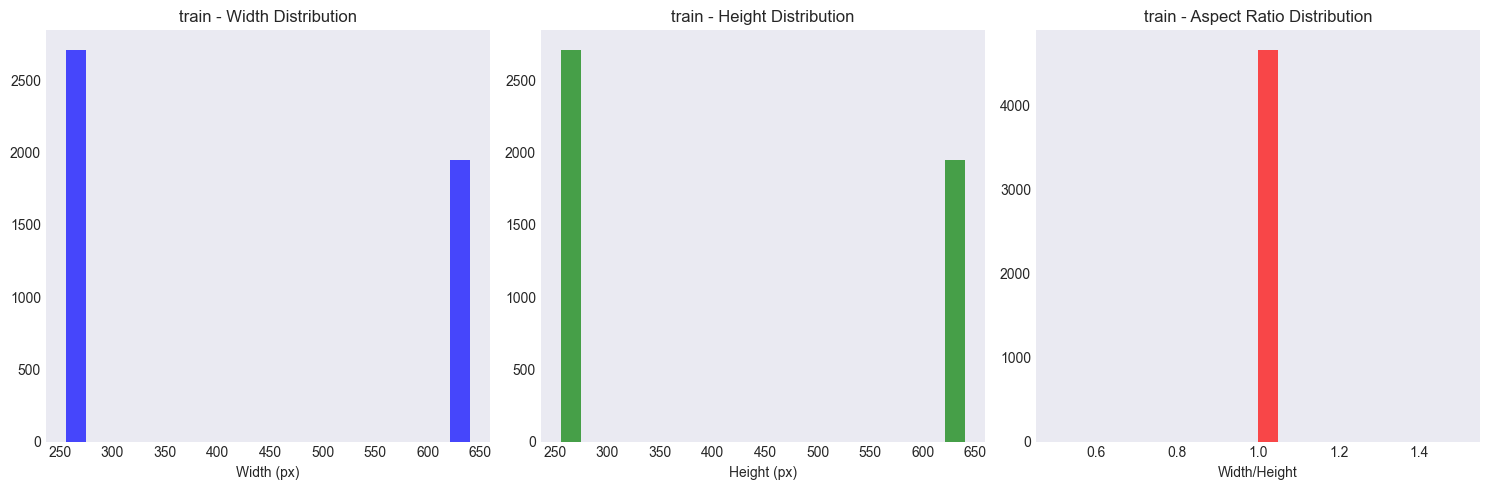

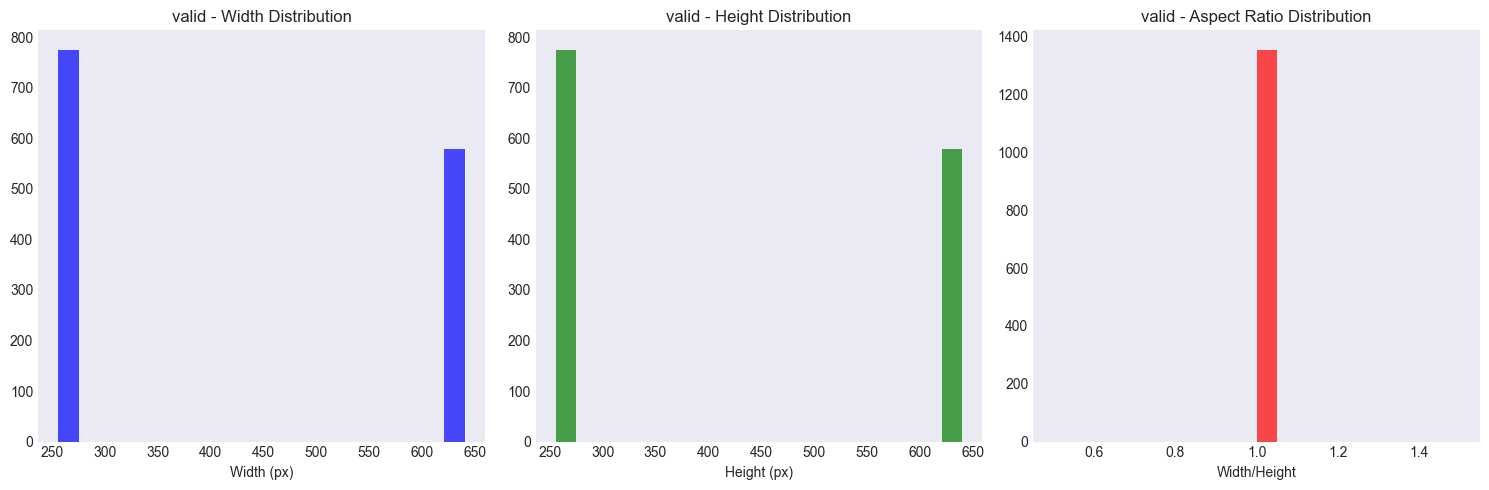

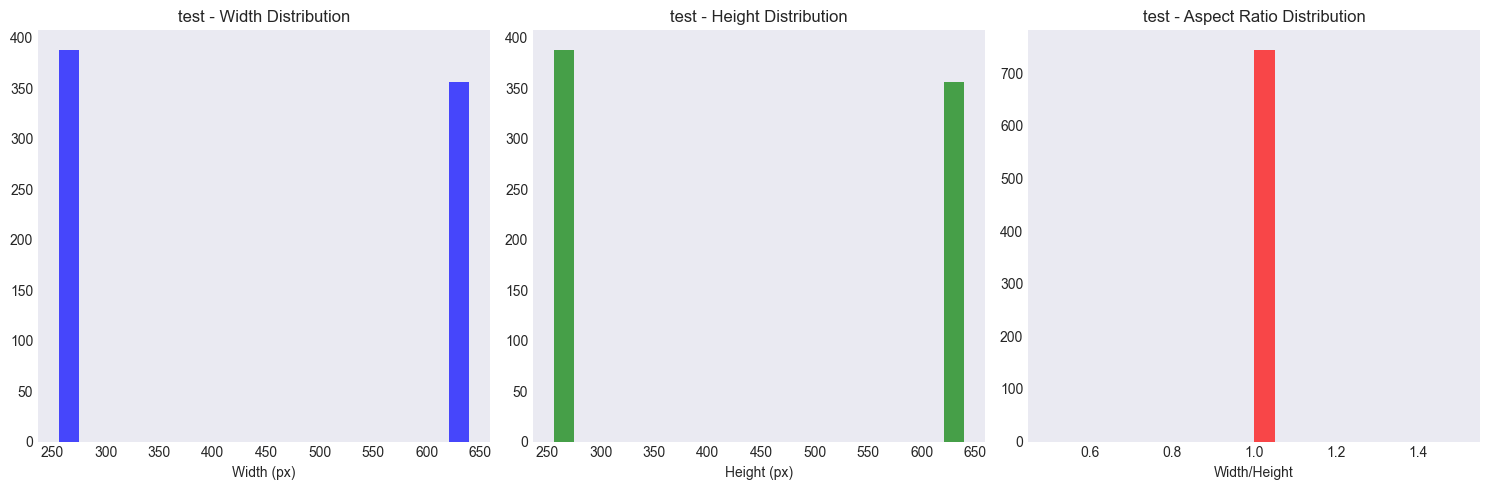

In [8]:
def analyze_image_sizes(data_dir: str, splits: list = SPLITS):
    """
    Analyzes image dimensions across different dataset splits.
    
    Args:
        data_dir (str): Path to the root dataset directory containing split folders
        splits (list): List of dataset split names to analyze (default: SPLITS)
        
    Returns:
        dict: Dictionary containing size statistics for each split with keys:
            - 'widths': List of image widths in pixels
            - 'heights': List of image heights in pixels  
            - 'aspect_ratios': List of width/height ratios
    """
    size_stats = {}
    for split in splits:
        split_path = os.path.join(data_dir, split)
        ann_file = os.path.join(split_path, ANNOTATION_FILENAME)
        
        data = load_coco_annotations(ann_file)
        if not data:
            continue
            
        sizes = []
        for img in data['images']:
            sizes.append((img['width'], img['height']))
        
        if sizes:
            widths, heights = zip(*sizes)
            size_stats[split] = {
                'widths': widths,
                'heights': heights,
                'aspect_ratios': [w/h for w, h in sizes]
            }
    
    return size_stats

size_stats = analyze_image_sizes(MERGED_DATASET_DIR)

for split, stats in size_stats.items():
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(stats['widths'], bins=20, color='blue', alpha=0.7)
    plt.title(f'{split} - Width Distribution')
    plt.xlabel('Width (px)')
    
    plt.subplot(1, 3, 2)
    plt.hist(stats['heights'], bins=20, color='green', alpha=0.7)
    plt.title(f'{split} - Height Distribution')
    plt.xlabel('Height (px)')
    
    plt.subplot(1, 3, 3)
    plt.hist(stats['aspect_ratios'], bins=20, color='red', alpha=0.7)
    plt.title(f'{split} - Aspect Ratio Distribution')
    plt.xlabel('Width/Height')
    
    plt.tight_layout()
    plt.show()

## Images Visualization


--- Displaying samples from train split ---
Displaying: ../data/merged_wildfire_dataset/train/CBERS_4A_WFI_20200827_222_132_L4_4971_3627_3_png_jpg.rf.2a0bd89e1be30fcc05519f5d57df4d8b.jpg (Image ID: 4271) with 3 annotations.


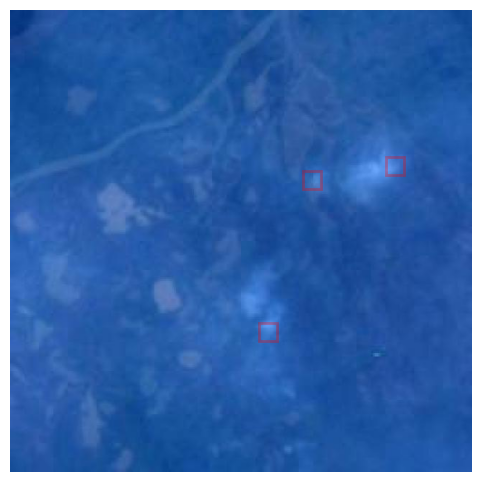

Displaying: ../data/merged_wildfire_dataset/train/CBERS_4A_WFI_20200726_216_140_L4_4925_3897_8_png.rf.7d7d37d13f473e72d0239d6a67ef2ae6.jpg (Image ID: 1220) with 9 annotations.


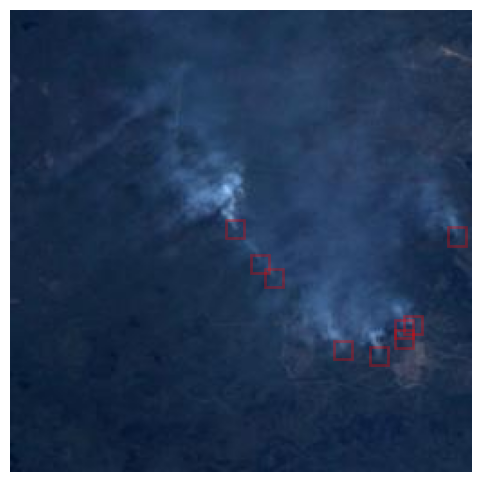

Displaying: ../data/merged_wildfire_dataset/train/CBERS_4A_WFI_20200701_221_140_L4_9905_2467_1_png.rf.0d5dcf8456d003860bafaedbee6fa004.jpg (Image ID: 537) with 1 annotations.


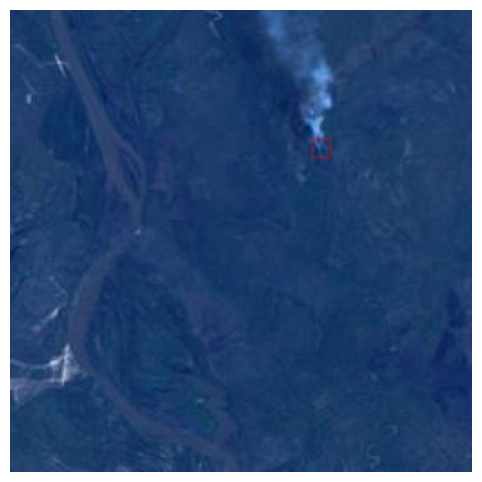

Displaying: ../data/merged_wildfire_dataset/train/CBERS_4A_WFI_20200721_217_140_L4_6426_3078_7_png.rf.ef8275699dce420ae7ce91fa8a72cc0b.jpg (Image ID: 2550) with 9 annotations.


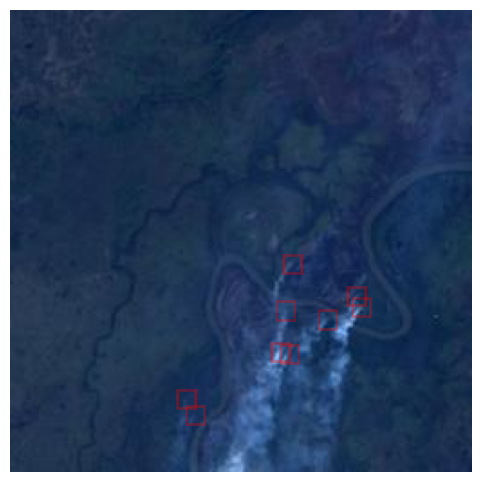

Displaying: ../data/merged_wildfire_dataset/train/CBERS_4A_WFI_20200806_220_132_L4_2059_5852_9_png_jpg.rf.5e22e5bbdcfed3f42e95ba288023c666.jpg (Image ID: 4307) with 15 annotations.


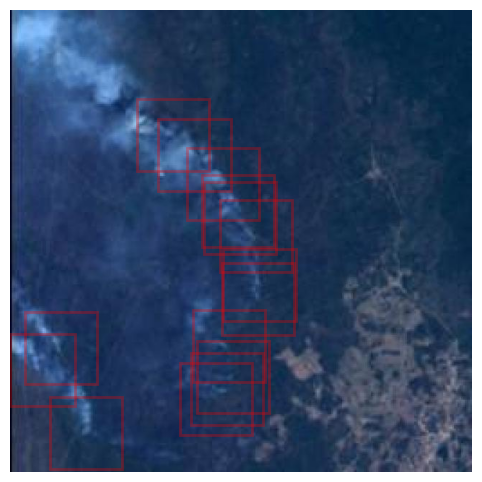

In [9]:
def display_image_with_annotations(img_path: str, annotations_for_img: list, categories_map: dict):
    """
    Displays an image with its bounding box annotations.
    
    Args:
        img_path (str): Path to the image file.
        annotations_for_img (list): List of annotation dicts for this specific image.
        categories_map (dict): Mapping from category_id to category_name.
    """
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return
        
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        return
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(9, 6))
    ax.imshow(image)
    
    for ann in annotations_for_img:
        bbox = ann.get('bbox') # [x_min, y_min, width, height]
        category_id = ann.get('category_id')
        
        if bbox and category_id is not None:
            category_name = categories_map.get(category_id, "Unknown")
            
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                   linewidth=2, edgecolor='r', facecolor='none', alpha=0.3)
            ax.add_patch(rect)
        else:
            print(f"Skipping annotation due to missing bbox or category_id: {ann}")
            
    plt.axis('off')
    plt.show()

num_samples_to_show = 5
target_split_for_viz = 'train'

print(f"\n--- Displaying samples from {target_split_for_viz} split ---")

if target_split_for_viz in dataset_stats and dataset_stats[target_split_for_viz]["num_images"] > 0:
    split_path = os.path.join(MERGED_DATASET_DIR, target_split_for_viz)
    ann_file = os.path.join(split_path, ANNOTATION_FILENAME)
    current_split_data = load_coco_annotations(ann_file) 

    if current_split_data:
        images_base_path = split_path 

        split_categories_map = dataset_stats[target_split_for_viz]["categories_present"]
        if not split_categories_map:
            print(f"Warning: No categories map found for {target_split_for_viz} split in dataset_stats. Using overall map.")
            split_categories_map = all_categories_map

        img_id_to_anns = {}
        for ann in current_split_data.get('annotations', []):
            img_id = ann['image_id']
            if img_id not in img_id_to_anns:
                img_id_to_anns[img_id] = []
            img_id_to_anns[img_id].append(ann)
            
        all_images_info = current_split_data.get('images', [])
        if not all_images_info:
            print(f"No image information found in {target_split_for_viz} annotations.")
        else:
            sample_images_info = []
            if len(all_images_info) >= num_samples_to_show:
                sample_images_info = np.random.choice(all_images_info, num_samples_to_show)
            else:
                sample_images_info = all_images_info
            
            for img_info in sample_images_info:
                img_filename = img_info['file_name']
                img_id = img_info['id']
                img_path = os.path.join(images_base_path, img_filename)
                
                annotations_for_this_image = img_id_to_anns.get(img_id, [])
                
                print(f"Displaying: {img_path} (Image ID: {img_id}) with {len(annotations_for_this_image)} annotations.")
                display_image_with_annotations(img_path, annotations_for_this_image, split_categories_map)
else:
    print(f"No images or data found for visualization in the '{target_split_for_viz}' split.")

## Annotation Density Analysis

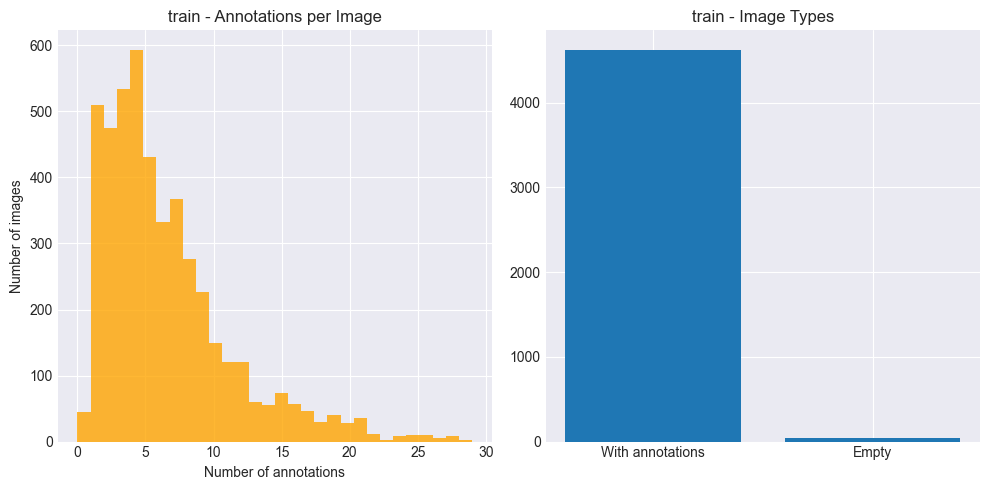

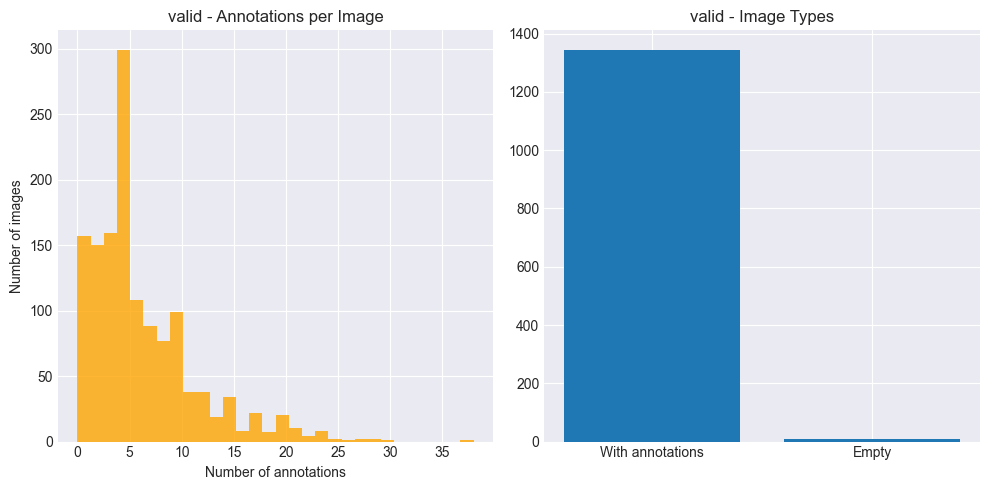

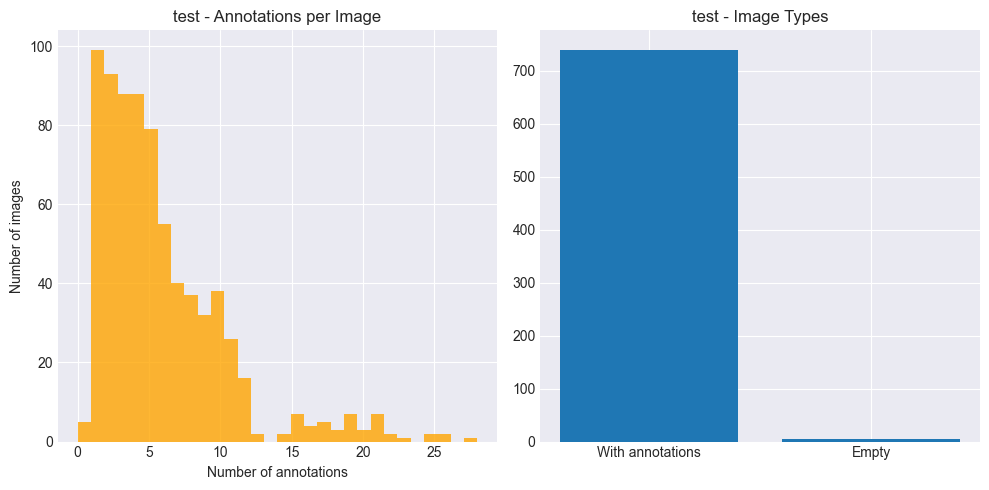

In [10]:
def analyze_annotation_density(data_dir, splits=SPLITS):
    density_stats = {}
    for split in splits:
        split_path = os.path.join(data_dir, split)
        ann_file = os.path.join(split_path, ANNOTATION_FILENAME)
        
        data = load_coco_annotations(ann_file)
        if not data:
            continue
            
        annotations_per_image = []
        for img in data['images']:
            img_anns = [ann for ann in data.get('annotations', []) 
                       if ann['image_id'] == img['id']]
            annotations_per_image.append(len(img_anns))
        
        density_stats[split] = {
            'annotations_per_image': annotations_per_image,
            'empty_images': sum(1 for count in annotations_per_image if count == 0)
        }
    
    return density_stats

density_stats = analyze_annotation_density(MERGED_DATASET_DIR)

for split, stats in density_stats.items():
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(stats['annotations_per_image'], bins=30, color='orange', alpha=0.8)
    plt.title(f'{split} - Annotations per Image')
    plt.xlabel('Number of annotations')
    plt.ylabel('Number of images')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.bar(['With annotations', 'Empty'], 
            [len(stats['annotations_per_image']) - stats['empty_images'], 
            stats['empty_images']])
    plt.title(f'{split} - Image Types')
    plt.grid()

    plt.tight_layout()
    plt.show()

## Spatial Distribution of Annotations

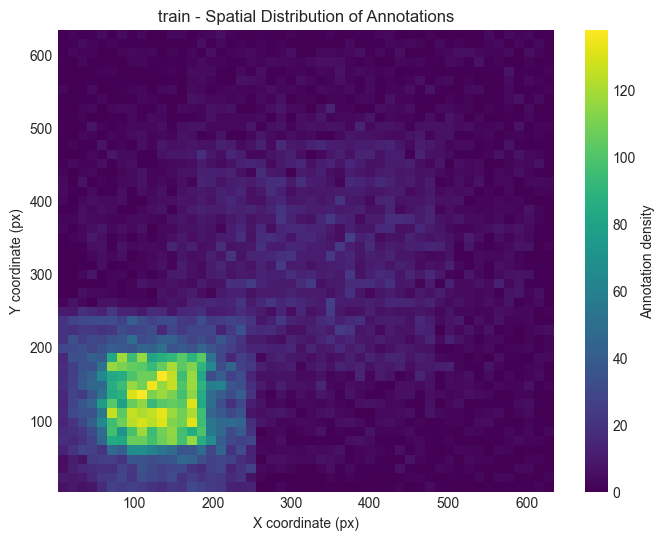

In [11]:
def plot_spatial_distribution(data_dir, split='train'):
    split_path = os.path.join(data_dir, split)
    ann_file = os.path.join(split_path, ANNOTATION_FILENAME)
    
    data = load_coco_annotations(ann_file)
    if not data:
        return

    centers_x = []
    centers_y = []
    
    for ann in data['annotations']:
        bbox = ann['bbox']
        centers_x.append(bbox[0] + bbox[2]/2)
        centers_y.append(bbox[1] + bbox[3]/2)
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.hist2d(centers_x, centers_y, bins=50, cmap='viridis')
    plt.colorbar(label='Annotation density')
    plt.title(f'{split} - Spatial Distribution of Annotations')
    plt.xlabel('X coordinate (px)')
    plt.ylabel('Y coordinate (px)')
    plt.show()

plot_spatial_distribution(MERGED_DATASET_DIR)